In [4]:
import statsmodels as sm
import numpy as np
import cPickle
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('/Users/zbutler/research/fire_prediction')
import prediction.poisson_regression as pr
%matplotlib inline

In [6]:
# First, load our dataset
with open('data/global_df.pkl') as fpkl:
    global_df = cPickle.load(fpkl)
global_df[0:10]

,day,dayofyear,humidity,month,n_clusters,n_det,temp,vpd,year
0,18,107,95.671989,4,1,1,273.587115,0.033115,2010
1,19,108,97.289916,4,0,0,274.493417,0.024588,2010
2,20,109,96.000420,4,0,0,274.798599,0.034974,2010
3,21,110,92.122409,4,0,0,273.890056,0.063110,2010
4,22,111,90.507283,4,0,0,274.882213,0.085641,2010
5,23,112,90.452101,4,1,5,273.967087,0.077605,2010
6,24,113,88.563305,4,0,0,272.780952,0.078633,2010
7,25,114,85.782913,4,0,0,271.798459,0.097492,2010
8,26,115,86.195938,4,0,0,273.574790,0.117322,2010
9,27,116,92.529552,4,0,0,274.878992,0.075596,2010


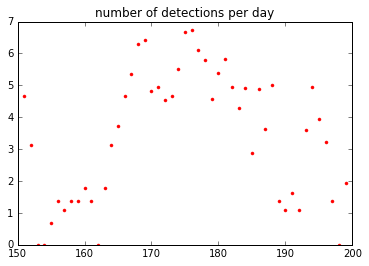

In [190]:
# some basic plots
annual_df = global_df[(global_df.year == 2013) & (global_df.dayofyear > 150) & (global_df.dayofyear < 200)]
#yearfloatarr = global_df.year + (global_df.dayofyear / 365.)
plt.plot(annual_df.dayofyear, np.log(annual_df.n_det+1), 'r.')
plt.title('number of detections per day')
plt.show()

In [60]:
# let's try making a prediction dataset. i guess this should be in carpentry/, i'll throw it there later
def create_dataset(df, normalize_feats=True):
    years = df.year.unique()
    X = pd.DataFrame()
    y = np.zeros((0))
    for year in years:
        annual_df = df[df.year == year]
        max_day = np.max(annual_df.dayofyear)
        min_day = np.min(annual_df.dayofyear)
        X = pd.concat((X, annual_df[annual_df.dayofyear != max_day]))
        y = np.concatenate((y, np.array(annual_df.n_det[annual_df.dayofyear != min_day])))
    if normalize_feats:
        X = (X - X.mean()) / X.std()
    return X,y

feat_df = global_df.loc[:,['dayofyear', 'humidity', 'n_clusters', 'n_det', 'temp', 'vpd', 'year']]
X, y = create_dataset(feat_df)
print X.iloc[0]
print y[0]

dayofyear    -1.777200
humidity      2.259404
n_clusters   -0.227585
n_det        -0.189639
temp         -1.264853
vpd          -1.311036
year         -1.463021
Name: 0, dtype: float64
0.0


In [61]:
import statsmodels.api as sm
X_const = sm.add_constant(X)
glm = sm.GLM(y, X_const, family=sm.genmod.families.family.Poisson(), missing='drop')
glm_res = glm.fit()

In [62]:
print global_df.columns[[2,4,5,6,7]]
glm_res.summary()


Index([u'humidity', u'n_clusters', u'n_det', u'temp', u'vpd'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1204
Model:                            GLM   Df Residuals:                     1196
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -43859.
Date:                Wed, 03 May 2017   Deviance:                       85141.
Time:                        14:14:50   Pearson chi2:                 1.41e+05
No. Iterations:                    11                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.0622      0.017    119.305      0.000         2.028     2.096
dayofyear     -0.5326      0.012    -43.658      0.000        -0.556    -0.509
humidity      -0.8169      0.016    -50.562      0.000        -0.849    -0.785
n_clusters     0.4177      0.003    157.262      0.000         0.413     0.423
n_det         -0.1664      0.002    -69.814      0.000        -0.171    -0.162
temp           1.9001      0.030     63.575      0.000         1.842     1.959
vpd           -0.7041      0.019    -37.914      0.000        -0.740    -0.668
year           0.0849      0.005     16.049      0.000         0.075     0.095
==============================================================================
"""

In [182]:
# Train/test split
def train_test_split(df, years_in_test=1, normalize_feats=True, feat_cols=['dayofyear', 'n_det', 'vpd']):
    years = df.year.unique()
    perm = np.random.permutation(years)
    test_years = perm[0:years_in_test]
    train_years = perm[years_in_test:]
    print "Train years: " + str(train_years)
    print "Test years: " + str(test_years)
    X_train = pd.DataFrame()
    y_train = np.zeros((0))
    for year in train_years:
        annual_df = df[df.year == year]
        max_day = np.max(annual_df.dayofyear)
        min_day = np.min(annual_df.dayofyear)
        X_train = pd.concat((X_train, annual_df.loc[(annual_df.dayofyear != max_day), feat_cols]))
        y_train = np.concatenate((y_train, np.array(annual_df.n_det[annual_df.dayofyear != min_day])))
    if normalize_feats:
        X_mean = X_train.mean()
        X_std = X_train.std()
        X_train = (X_train - X_mean) / X_std
    X_train = sm.add_constant(X_train)
    
    X_test = pd.DataFrame()
    y_test = np.zeros((0))
    y_hat_base = np.zeros((0))
    for year in test_years:
        annual_df = df[df.year == year]
        max_day = np.max(annual_df.dayofyear)
        min_day = np.min(annual_df.dayofyear)
        X_test = pd.concat((X_test, annual_df.loc[(annual_df.dayofyear != max_day), feat_cols]))
        y_test = np.concatenate((y_test, np.array(annual_df.n_det[annual_df.dayofyear != min_day])))
        y_hat_base = np.concatenate((y_hat_base, np.array(annual_df.n_det[annual_df.dayofyear != max_day])))
    if normalize_feats:
        X_test = (X_test - X_mean) / X_std
    X_test = sm.add_constant(X_test)
    
    return X_train, y_train, X_test, y_test, y_hat_base

In [183]:
X_train, y_train, X_test, y_test, y_hat_base = train_test_split(global_df)
X_train_2, y_train_2, X_test_2, y_test_2, y_hat_base_2 = train_test_split(global_df, normalize_feats=False, feat_cols=['n_det'])
print "Shapes: " + str([X_train.shape, y_train.shape, X_test.shape, y_test.shape])

Train years: [2016 2015 2010 2014 2012 2013]
Test years: [2011]
Train years: [2011 2013 2014 2015 2016 2010]
Test years: [2012]
Shapes: [(1075, 4), (1075,), (175, 4), (175,)]


In [184]:
glm = sm.GLM(y_train, X_train, family=sm.genmod.families.family.Poisson(), missing='drop')
glm_res = glm.fit()
print glm_res.summary()
glm_2 = sm.GLM(y_train_2, X_train_2, family=sm.genmod.families.family.Poisson(), missing='drop')
glm_res_2 = glm_2.fit()
print glm_res_2.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1032
Model:                            GLM   Df Residuals:                     1028
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -61344.
Date:                Thu, 04 May 2017   Deviance:                   1.2033e+05
Time:                        16:34:20   Pearson chi2:                 2.67e+05
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.1378      0.007    446.831      0.000         3.124     3.152
dayofyear     -0.2930      0.008    -35.887      0.0

In [191]:
def evaluate_glm(y, y_hat, ignore_nans=True):
    if ignore_nans:
        non_nans = (1 - np.isnan(y_hat)).astype(bool)
        y = y[non_nans]
        y_hat = y_hat[non_nans]
        print "skipped %d" %(len(y) - np.sum(non_nans))
    return np.mean((y - y_hat)**2)
y_hat = glm_res.predict(X_test)
y_hat_train = glm_res.predict(X_train)
y_hat_2 = glm_res_2.predict(X_test_2)
print "MSE training: " + str(evaluate_glm(y_train, y_hat_train))
print "MSE model full: " + str(evaluate_glm(y_test, y_hat))
print "MSE model auto: " + str(evaluate_glm(y_test_2, y_hat_2))
print "MSE base: " + str(evaluate_glm(y_test, y_hat_base))
print "MSE zeros: " + str(evaluate_glm(y_test, np.zeros(len(y_test))))
print np.mean((y_test - y_hat_base)**2)

skipped 0
MSE training: 66895.7019503
skipped 0
MSE model full: 1122.96682006
skipped 0
MSE model auto: 1680.37258972
skipped 0
MSE base: 496.028571429
skipped 0
MSE zeros: 1123.68
496.028571429


mean: 29.06069673
max: 194.812253416
min: 4.35712824314


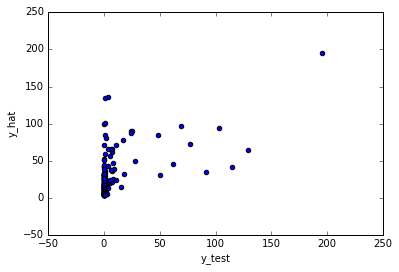

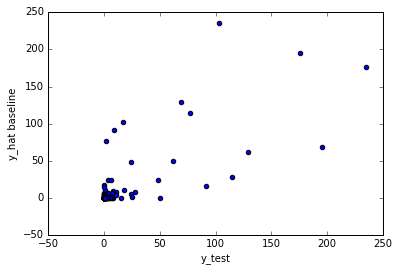

In [192]:
y_hat_nn = y_hat[np.logical_not(np.isnan(y_hat))]
print "mean: " + str(np.mean(y_hat_nn))
print "max: " + str(np.max(y_hat_nn))
print "min: " + str(np.min(y_hat_nn))
y_test_nn = y_test[np.logical_not(np.isnan(y_hat))]
plt.scatter(y_test_nn, y_hat_nn)
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.show()
plt.close()
plt.scatter(y_test, y_hat_base)
plt.xlabel('y_test')
plt.ylabel('y_hat baseline')
plt.show()

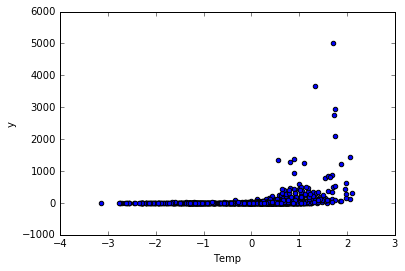

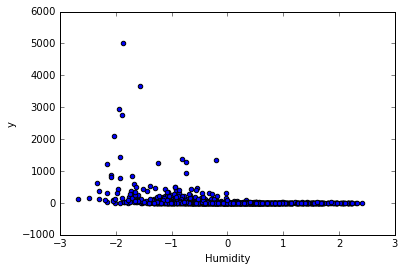

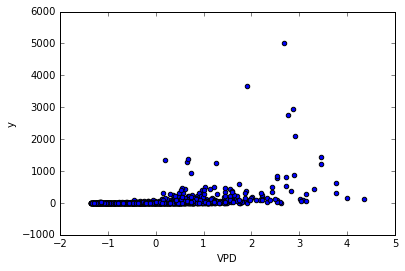

In [136]:
# Now lets plot some covariates 
plt.scatter(X_train.temp, y_train)
plt.xlabel('Temp')
plt.ylabel('y')
plt.show()
plt.close()
plt.scatter(X_train.humidity, y_train)
plt.xlabel('Humidity')
plt.ylabel('y')
plt.show()
plt.close()
plt.scatter(X_train.vpd, y_train)
plt.xlabel('VPD')
plt.ylabel('y')
plt.show()
plt.close()

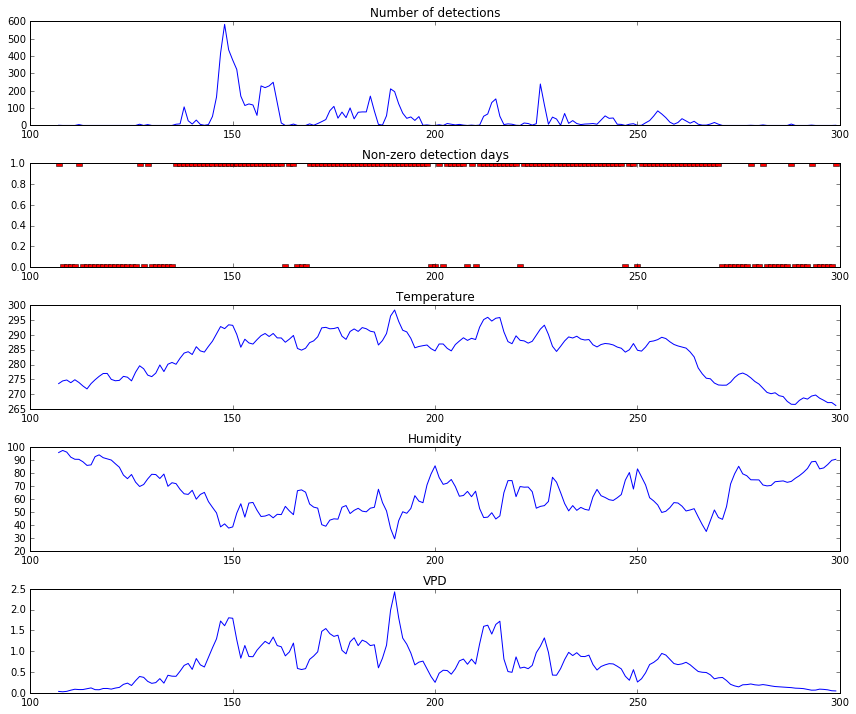

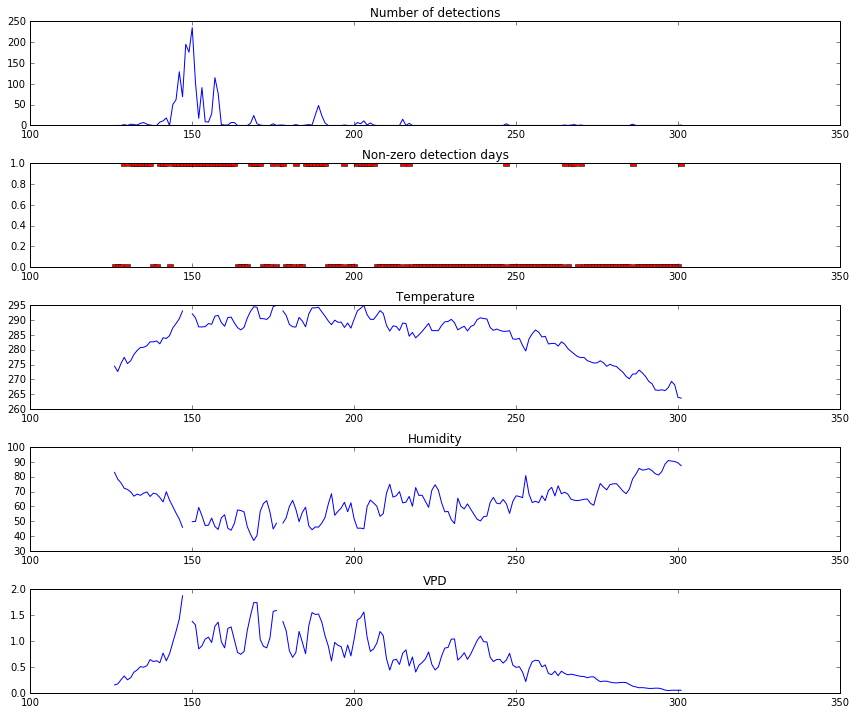

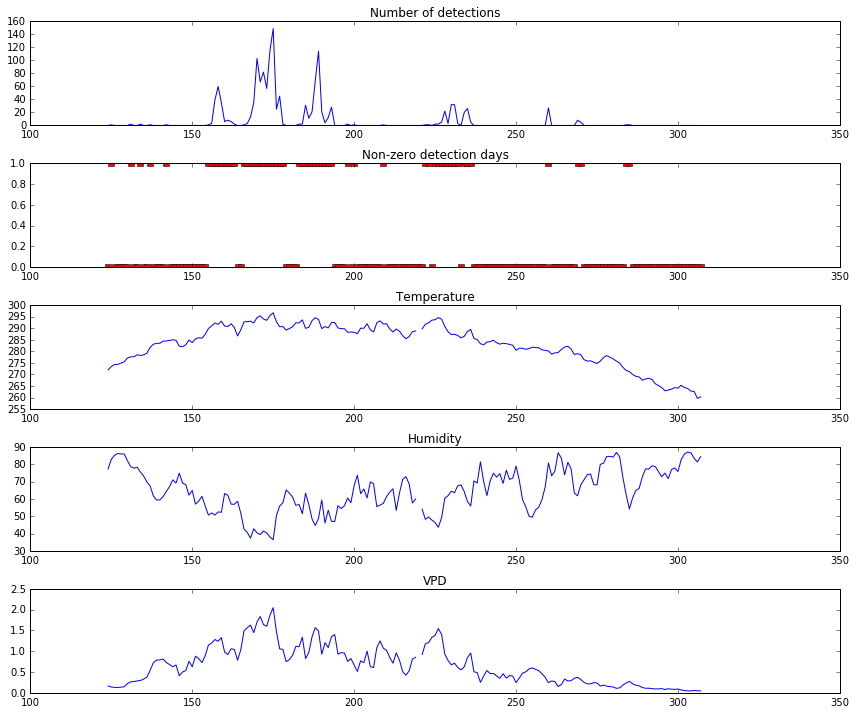

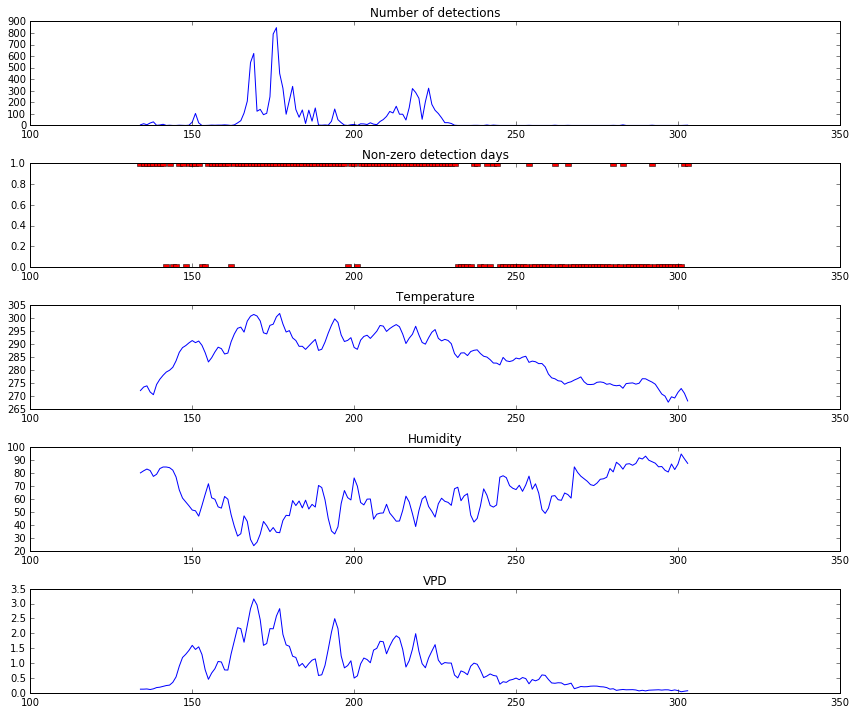

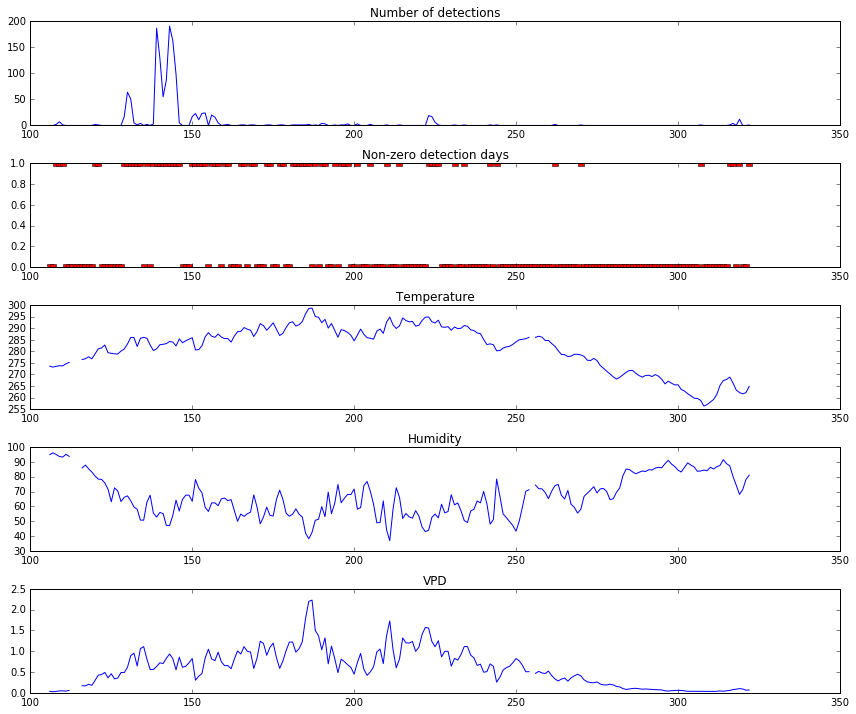

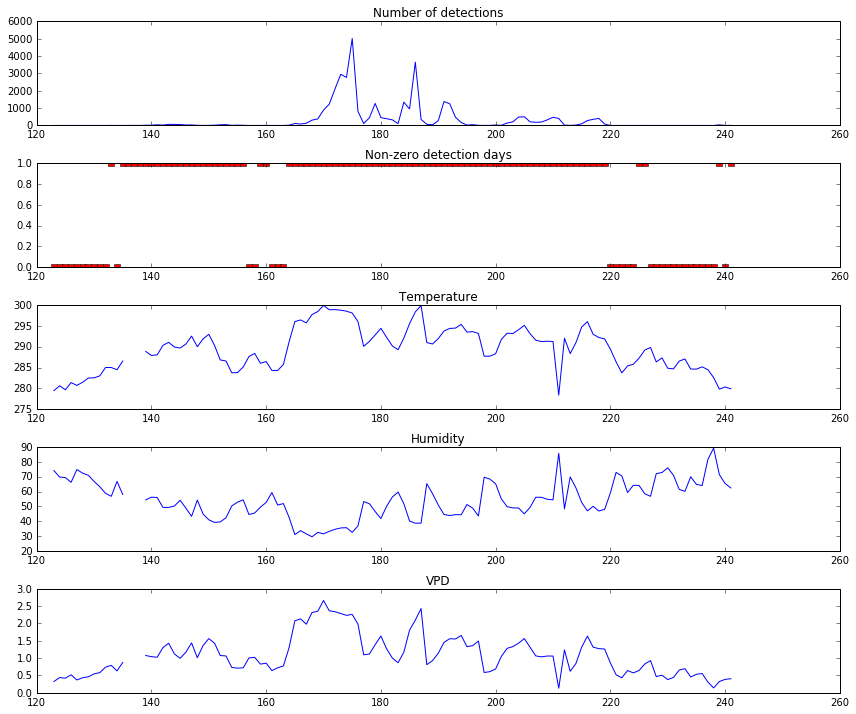

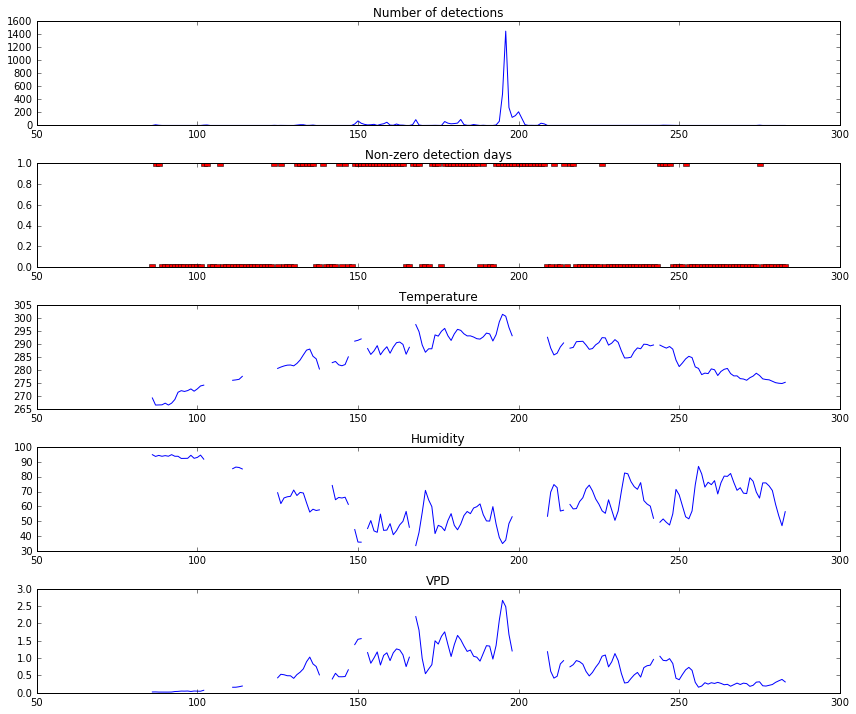

In [369]:
# The plot Jim wanted to see
for year in xrange(2010,2017):
    annual_fires = global_df[global_df.year == year]
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,10))
    ax1 = plt.subplot(511)
    plt.plot(annual_fires.dayofyear, annual_fires.n_det)
    plt.title('Number of detections')

    ax2 = plt.subplot(512, sharex=ax1)
    plt.plot(annual_fires.dayofyear, annual_fires.n_det != 0, 'rs')
    plt.title('Non-zero detection days')

    ax3 = plt.subplot(513, sharex=ax1)
    plt.plot(annual_fires.dayofyear, annual_fires.temp)
    plt.title('Temperature')

    ax4 = plt.subplot(514, sharex=ax1)
    plt.plot(annual_fires.dayofyear, annual_fires.humidity)
    plt.title('Humidity')

    ax5 = plt.subplot(515)
    plt.plot(annual_fires.dayofyear, annual_fires.vpd)
    plt.title('VPD')

    fig.tight_layout()
    plt.savefig('pics/covar_subplot_%d.png' % year)

In [245]:
from util.daymonth import day2monthday
print day2monthday(242)

(8, 31)


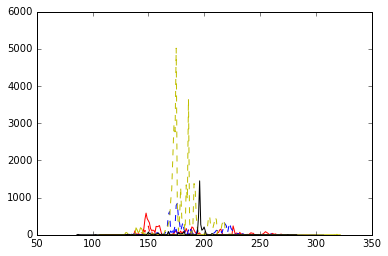

In [229]:
# Plot counts on top of each other for each year
col_arr = ['r-', 'r--', 'b-', 'b--', 'y-', 'y--', 'k-', 'k--', 'g-']
for i,year in enumerate(xrange(2010, 2017)):
    annual_fires = global_df[global_df.year == year]
    plt.plot(annual_fires.dayofyear, annual_fires.n_det, col_arr[i])
plt.show()

In [247]:
print "%d fires" % np.sum(global_df.n_det)
print "%d before 134, %d after 242" % (np.sum(global_df[global_df.dayofyear<134].n_det), np.sum(global_df[global_df.dayofyear>242].n_det))

60526 fires
240 before 134, 723 after 242


Train years: [2014 2010 2016 2011 2012 2015]
Test years: [2013]
Shapes: [(647, 5), (647,), (108, 5), (108,)]
skipped 0
MSE model full: 101585.50456
skipped 0
MSE base: 11737.9907407
skipped 0
MSE zeros: 31135.1759259


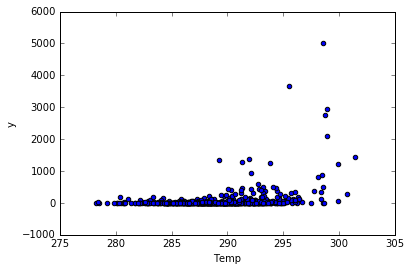

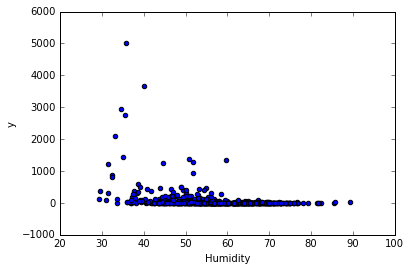

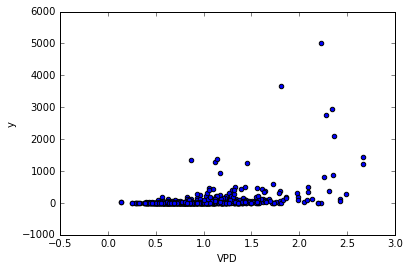

In [253]:
summer_df = global_df[(global_df.dayofyear >= 134) & (global_df.dayofyear <= 242)]
X_train, y_train, X_test, y_test, y_hat_base = train_test_split(summer_df, feat_cols=['n_det', 'temp', 'vpd', 'humidity'], normalize_feats=False)
print "Shapes: " + str([X_train.shape, y_train.shape, X_test.shape, y_test.shape])
glm = sm.GLM(y_train, X_train, family=sm.genmod.families.family.Poisson(), missing='drop')
glm_res = glm.fit()
y_hat = glm_res.predict(X_test)
print "MSE model full: " + str(evaluate_glm(y_test, y_hat))
print "MSE base: " + str(evaluate_glm(y_test, y_hat_base))
print "MSE zeros: " + str(evaluate_glm(y_test, np.zeros(len(y_test))))
plt.scatter(X_train.temp, y_train)
plt.xlabel('Temp')
plt.ylabel('y')
plt.show()
plt.close()
plt.scatter(X_train.humidity, y_train)
plt.xlabel('Humidity')
plt.ylabel('y')
plt.show()
plt.close()
plt.scatter(X_train.vpd, y_train)
plt.xlabel('VPD')
plt.ylabel('y')
plt.show()
plt.close()

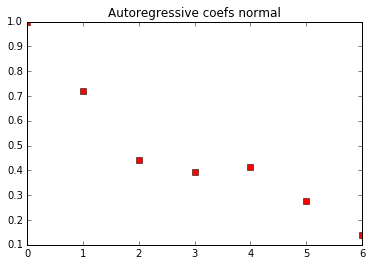

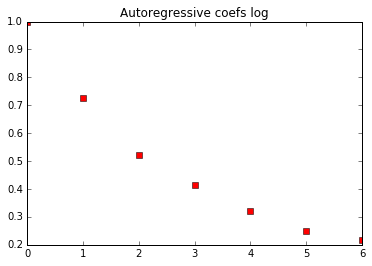

In [267]:
n_delays = 7
auto_arr = np.zeros(n_delays)
det_arr = np.array(summer_df[summer_df.year==2014].n_det)
for delay in xrange(n_delays):
    auto_arr[delay] = np.corrcoef(np.array([det_arr[0:len(det_arr)-delay], det_arr[delay:]]))[0,1]
plt.plot(auto_arr, 'rs')
plt.title('Autoregressive coefs normal')
plt.show()

auto_arr = np.zeros(n_delays)
det_arr = np.array(summer_df[summer_df.year==2014].n_det)
for delay in xrange(n_delays):
    auto_arr[delay] = np.corrcoef(np.array([np.log(det_arr[0:len(det_arr)-delay]+1), np.log(det_arr[delay:]+1)]))[0,1]
plt.plot(auto_arr, 'rs')
plt.title('Autoregressive coefs log')
plt.show()

In [299]:
X, y, y_dates = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd'], log_counts=True, autocorr_window=5)
X_train, y_train, y_dates_train, X_test, y_test, y_dates_test = pr.train_test_split(X,y,y_dates)

[  0 205   2  43   2   0   0   0  53   0]
[(223, 2016), (203, 2015), (174, 2016), (196, 2015), (206, 2016), (216, 2011), (147, 2012), (209, 2014), (221, 2013), (144, 2013)]


In [304]:
glm_res = pr.get_glm(X_train, y_train)
glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  563
Model:                            GLM   Df Residuals:                      560
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -24217.
Date:                Wed, 10 May 2017   Deviance:                       53493.
Time:                        18:16:32   Pearson chi2:                 1.16e+05
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
n_det          0.8472      0.002    471.758      0.000         0.844     0.851
normtemp       0.4095      0.021     19.687      0.000         0.369     0.450
normvpd        0.3457      0.014     25.453      0.000         0.319     0.372
==============================================================================
"""

skipped 0
MSE model (log): 4.33521638138
skipped 0
MSE base (log): 9.01657421095
skipped 0
MSE zeros (log): 3.90618573391
skipped 0
MSE model (nz): 280.710659282
skipped 0
MSE base (nz): 17280.5630864
skipped 0
MSE zeros (nz): 20649.69


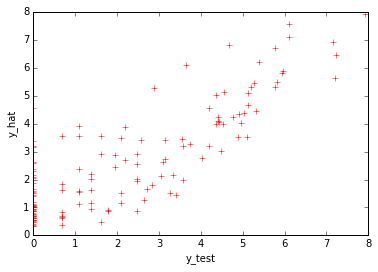

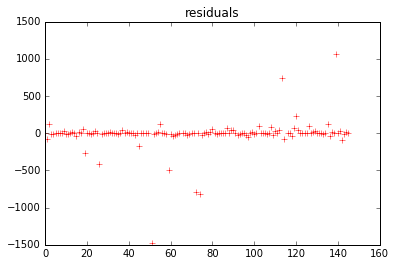

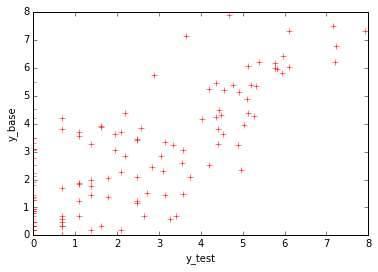

In [368]:
y_hat = glm_res.predict(X_test)
print "MSE model (log): " + str(pr.evaluate_glm(y_test, y_hat, log=True))
print "MSE base (log): " + str(pr.evaluate_glm(y_test, np.exp(X_test.loc[:,'n_det']), log=True))
print "MSE zeros (log): " + str(pr.evaluate_glm(y_test, np.zeros(len(y_test)), log=True))
nzs = y_test != 0
print "MSE model (nz): " + str(pr.evaluate_glm(y_test[nzs], y_hat[nzs]))
print "MSE base (nz): " + str(pr.evaluate_glm(y_test[nzs], np.exp(X_test.loc[:,'n_det'])[nzs]))
print "MSE zeros (nz): " + str(pr.evaluate_glm(y_test[nzs], np.zeros(np.sum(nzs))))
plt.plot(np.log(y_test+1), np.log(y_hat+1), 'r+')
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.show()

plt.plot(y_test - y_hat, 'r+')
plt.title("residuals")
plt.show()

plt.plot(np.log(y_test+1), X_test.loc[:,'n_det'], 'r+')
plt.xlabel('y_test')
plt.ylabel('y_base')
plt.show()

In [343]:
reload(pr)
X1, y1, y1_dates = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd'], normalize=[1,1], log_counts=True, autocorr_window=5)
X2, y2, y2_dates = pr.get_regression_df(summer_df, covar_cols=['vpd'], normalize=[1,1], log_counts=False, autocorr_window=5)
X3, y3, y3_dates = pr.get_regression_df(summer_df, covar_cols=[], normalize=[], log_counts=True, autocorr_window=1)
X4, y4, y4_dates = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd'], normalize=[1,1], log_counts=False, autocorr_window=1)
X1_train, y1_train, X1_test, y1_test = pr.train_test_split(X,y)
idx = np.concatenate((X1_train.index, X1_test.index))
X2_train, y2_train, X2_test, y2_test = pr.train_test_split(X2,y2,idx=idx)
X3_train, y3_train, X3_test, y3_test = pr.train_test_split(X3,y3,idx=idx)
X4_train, y4_train, X4_test, y4_test = pr.train_test_split(X4,y4,idx=idx)
glm_res1 = pr.get_glm(X1_train, y1_train)
glm_res2 = pr.get_glm(X2_train, y2_train)
glm_res3 = pr.get_glm(X3_train, y3_train)
glm_res4 = pr.get_glm(X4_train, y4_train)
y1_hat = glm_res1.predict(X1_test)
y2_hat = glm_res2.predict(X2_test)
y3_hat = glm_res3.predict(X3_test)
y4_hat = glm_res4.predict(X4_test)
print "MSE model1: " + str(pr.evaluate_glm(y1_test, y1_hat))
print "MSE model2: " + str(pr.evaluate_glm(y1_test, y2_hat))
print "MSE model3: " + str(pr.evaluate_glm(y1_test, y3_hat))
print "MSE model4: " + str(pr.evaluate_glm(y1_test, y4_hat))
print "MSE base (log): " + str(pr.evaluate_glm(y1_test, X3_test.loc[:,'n_det']))
print "MSE base (not log): " + str(pr.evaluate_glm(y1_test, np.exp(X3_test.loc[:,'n_det'])))
print "MSE zeros: " + str(pr.evaluate_glm(y1_test, np.zeros(len(y1_test))))

skipped 0
MSE model1: 1544.3456931
skipped 0
MSE model2: 7145.86681058
skipped 0
MSE model3: 4828.29452924
skipped 0
MSE model4: 5072.01694682
skipped 0
MSE base (log): 15060.3399305
skipped 0
MSE base (not log): 2237.36691123
skipped 0
MSE zeros: 14785.5605648


In [353]:
import statsmodels.formula.api as smf
glm = smf.glm('n_det ~ normvpd', data=X1, family=sm.genmod.families.family.Poisson())
res = glm.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  n_det   No. Observations:                  706
Model:                            GLM   Df Residuals:                      704
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1404.9
Date:                Thu, 11 May 2017   Deviance:                       1190.1
Time:                        09:47:12   Pearson chi2:                 1.05e+03
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.8270      0.025     32.611      0.000         0.777     0.877
normvpd        0.2649      0.021     12.627      0.000         0.224     0.306
==============================================================================
"""

In [362]:
res.params

Intercept    0.826958
normvpd      0.264909
dtype: float64

In [363]:
for bro in 'bro':
    print bro

b
r
o


In [365]:
print "yolo %d" % 4,
print "swag"

yolo 4 swag
